<a href="https://colab.research.google.com/github/thunderdog101/Machine-Learning/blob/main/TelecomChurn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [407]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import tree

In [408]:
churn_data = pd.read_csv('https://raw.githubusercontent.com/thunderdog101/database/main/Telco-Customer-Churn.csv')

In [409]:
print('Number of NAN values: {}'.format(churn_data.TotalCharges.isna().sum()))

Number of NAN values: 0


In [410]:
churn_data.head()
# churn_data.shape

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


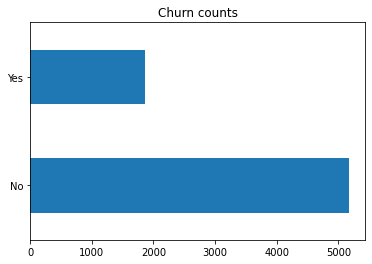

In [411]:
churn_data.Churn.value_counts().plot(kind='barh', title='Churn counts')
plt.show() 

In [412]:
churn_data = churn_data.replace(' ', np.nan)      # replace blank cells (one space) with NaN
churn_data.dropna(                                # remove rows with any blank cells
    axis=0,                                       # '0' to eliminate rows
    how='any',                                    # remove row if *any* cells are blank
    thresh=None,
    subset=None,
    inplace=True                                  # will not save unless set to True     
)
churn_data['TotalCharges'] = churn_data['TotalCharges'].astype(float).astype(int)     # change column from type object to int

In [413]:
churn_data.Churn = churn_data.Churn.replace({'Yes':1, 'No':0})                        # Replacing 'Yes' and 'No' with numerical values

In [414]:
y = churn_data.pop('Churn')                                                     # Removing Churn field and storing it in variable y... y is dependent variable

In [415]:
numerical_cols = churn_data.columns[churn_data.dtypes=='int64'].tolist()
numerical_cols

['SeniorCitizen', 'tenure', 'TotalCharges']

In [416]:
churn_data =  churn_data.drop('customerID', 1)            # remove customerID column to reduce computation time

In [417]:
categorical_cols = churn_data.columns[churn_data.dtypes=='object'].tolist()
categorical_cols

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [418]:
churn_data = pd.get_dummies(data = churn_data, columns=categorical_cols, drop_first=False)
churn_data

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29,1,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
1,0,34,56.95,1889,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1
2,0,2,53.85,108,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1
3,0,45,42.30,1840,0,1,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0
4,0,2,70.70,151,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,24,84.80,1990,0,1,0,1,0,1,0,1,0,0,1,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1
7039,0,72,103.20,7362,1,0,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0
7040,0,11,29.60,346,1,0,0,1,0,1,1,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
7041,1,4,74.40,306,0,1,0,1,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1


In [419]:
X = churn_data

# **Splitting data**

In [420]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.25)

In [421]:
X_train.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
6972,1,56,111.95,6418,1,0,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0
112,0,43,91.65,3954,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,1,0
1186,0,58,61.05,3478,1,0,0,1,1,0,0,1,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,1,1,0,0,0
6187,0,8,20.15,165,0,1,0,1,0,1,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,1
6731,0,24,19.55,470,1,0,1,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,1,0,0,0


In [422]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(max_depth=3)

print(dt_model)

dt_model = dt_model.fit(X_train,y_train)
pred_dt = dt_model.predict_proba(X_test)[:, 1]

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


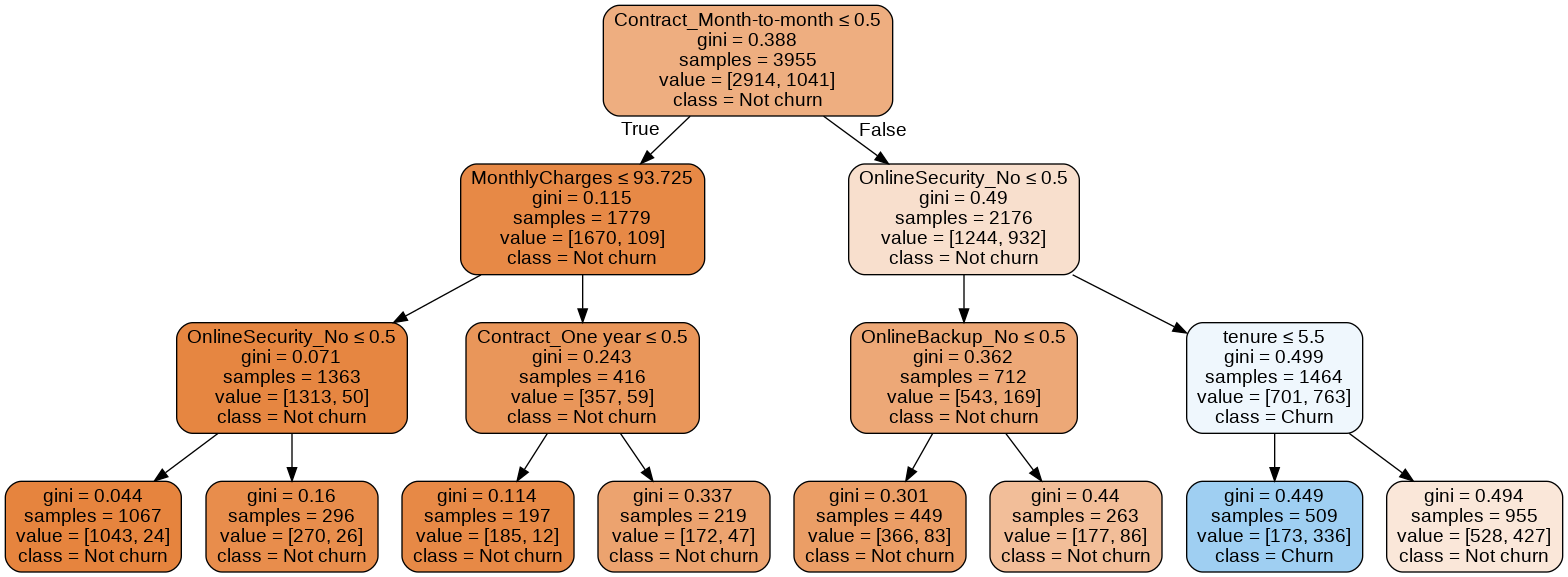

In [423]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(dt_model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = X_train.columns.values.tolist(), 
               class_names=['Not churn', 'Churn'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

The gini score is a metric that quantifies the purity of the node/leaf. A gini score greater than zero implies that samples contained within that node belong to different classes. A gini score of zero means that the node is pure, that within that node only a single class of samples exist. You can find out more about impurity measures here. Notice that we have a gini score greater than zero; therefore, we know that the samples contained within the root node belong to different classes.

In [424]:
from sklearn.metrics import classification_report
pred_dt_binary = dt_model.predict(X_test)
print(classification_report(y_test, pred_dt_binary))

              precision    recall  f1-score   support

           0       0.79      0.94      0.86      1291
           1       0.66      0.31      0.42       467

    accuracy                           0.77      1758
   macro avg       0.73      0.63      0.64      1758
weighted avg       0.76      0.77      0.74      1758



Precision tells us how many churned users our classifier predicted correctly. On the other side, recall tell us how many churned users it missed.

# **Random Forests**

In [425]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor()  

print(rf_model)

rf_model.fit(X_train, y_train)  
pred_rf = rf_model.predict(X_test)  

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)


n_estimators: This is the number of trees you want to build before taking the maximum voting or averages of predictions. Higher number of trees give you better performance but makes your code slower. You should choose as high value as your processor can handle because this makes your predictions stronger and more stable.

# **XGBoost**

In [426]:
from xgboost import XGBClassifier


xgb_model = XGBClassifier()

print(xgb_model)

xgb_model.fit(X_train, y_train)
pred_xgb =  xgb_model.predict_proba(X_test)[:, 1]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


# **Evaluating model**

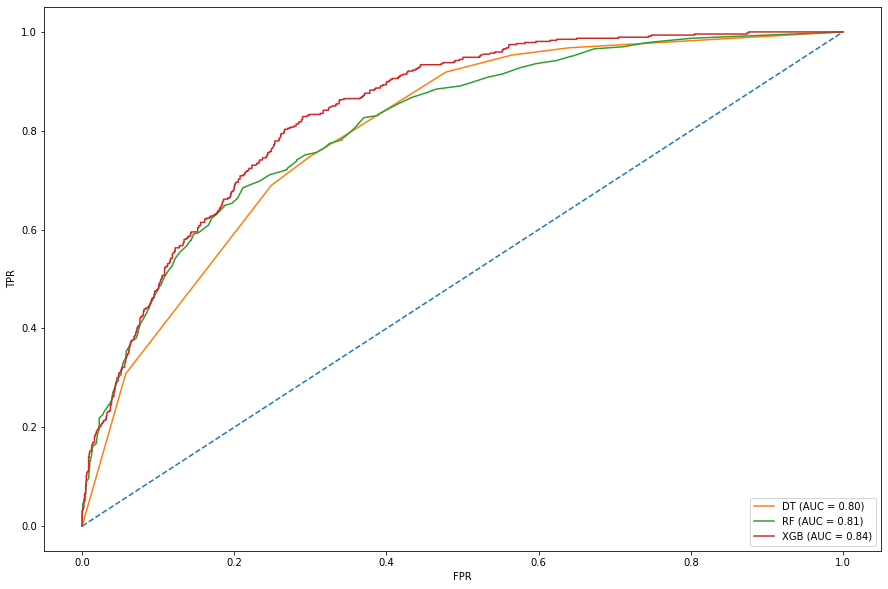

In [427]:
# calculate scores
auc_dt = roc_auc_score(y_test, pred_dt)
auc_rf = roc_auc_score(y_test, pred_rf)
auc_xgb = roc_auc_score(y_test, pred_xgb)



# calculate roc curves
fpr_dt, tpr_dt, _ = roc_curve(y_test, pred_dt)
fpr_rf, tpr_rf, _ = roc_curve(y_test, pred_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, pred_xgb)

plt.figure(figsize=(15, 10))
# plot horizontal line 
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_dt, tpr_dt, label='DT (AUC = %0.2f)' % auc_dt)
plt.plot(fpr_rf, tpr_rf, label='RF (AUC = %0.2f)' % auc_rf)
plt.plot(fpr_xgb, tpr_xgb, label='XGB (AUC = %0.2f)' % auc_xgb)

# axis labels
plt.xlabel('FPR')
plt.ylabel('TPR')
# show the legend
plt.legend(loc='lower right')
# show the plot
plt.show()